<h1>kNN Implementation </h1>
<h4> Mike Altschwager </h4>
Outlines a base scikit learn pipeline for using k Nearest Neighbors ratings to determine recommendations for a user. 

Lessons learned:

*

In [344]:
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix
import numpy as np

<h1> Load Data </h1>

In [345]:
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
original_movie_ids = set(movies_df["movieId"])
movie_id_map = {original : new for new, original in enumerate(original_movie_ids) }
movies_df["movieId"] = movies_df["movieId"].map(movie_id_map)
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
original_movie_ids = set(ratings_df["movieId"])
movie_id_map = {original : new for new, original in enumerate(original_movie_ids) }
ratings_df["movieId"] = ratings_df["movieId"].map(movie_id_map)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


<h1> Build Raiding Matrix </h1>

In [ ]:


# Get the unique user IDs and movie IDs
user_ids = ratings_df['userId'].unique()
movie_ids = ratings_df['movieId'].unique()

# Create a dictionary to map movie IDs to column indices
movie_id_map = {movie_id: i for i, movie_id in enumerate(movie_ids)}

In [ ]:
len(movie_ids)

59047

In [ ]:

# Initialize lists to store the row indices, column indices, and ratings
row_indices = []
col_indices = []
ratings = []

# Iterate over the ratings dataframe
for _, row in ratings_df.iterrows():
    row_indices.append(int(row['userId']))
    col_indices.append(int(row['movieId']))
    ratings.append(row['rating'])

In [ ]:
# Create the sparse spatial matrix
sparse_matrix = csr_matrix((ratings, (row_indices, col_indices)))
sparse_matrix.shape

(162542, 59047)

<h1> Test Train Split</h1>

In [ ]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(sparse_matrix, test_size=0.2, train_size=0.8)

Split Test Ratings per User into 80/20% split. We're doing this above the actual training logic so this doesn't have to recompute every time that logic is updated

In [ ]:
import numpy as np

# Initialize empty lists to store the row indices, column indices, and values
row_indices_80 = []
col_indices_80 = []
values_80 = []

row_indices_20 = []
col_indices_20 = []
values_20 = []

# Iterate over each row in test_dataset
for row_idx in range(test_dataset.shape[0]):
    # Get the non-zero indices and values for the current row
    non_zero_indices = test_dataset[row_idx].nonzero()[1]
    non_zero_values = test_dataset[row_idx].data
    
    # Calculate the number of non-zero values to include in the 80% matrix
    num_values_80 = int(len(non_zero_values) * 0.8)
    
    # Split the non-zero indices and values into 80% and 20% portions
    indices_80 = np.random.choice(non_zero_indices, size=num_values_80, replace=False)
    indices_20 = np.setdiff1d(non_zero_indices, indices_80)
    
    values_80.extend(non_zero_values[np.isin(non_zero_indices, indices_80)])
    values_20.extend(non_zero_values[np.isin(non_zero_indices, indices_20)])
    
    row_indices_80.extend([row_idx] * len(indices_80))
    row_indices_20.extend([row_idx] * len(indices_20))
    
    col_indices_80.extend(indices_80)
    col_indices_20.extend(indices_20)

# Create the 80% and 20% csc_matrix objects
input_ratings = csr_matrix((values_80, (row_indices_80, col_indices_80)))
test_ratings = csr_matrix((values_20, (row_indices_20, col_indices_20)))

#Need to resize the input_ratings and test_ratings to match the shape of the original test_dataset to fix the columns dropped for having no avg rating (due to no ratings existing period)
input_ratings.resize(test_dataset.shape)
test_ratings.resize(test_dataset.shape)


<h1> Define training function </h1>

In [ ]:
from scipy import sparse
from sklearn.base import BaseEstimator
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import vstack
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix

class KNNAverageRatingModel(BaseEstimator): 
    def GetAvgRatings(self, knn_user_ratings_matrix: csr_matrix):
        # Calculate the column-wise average of the sparse matrix
        averages = knn_user_ratings_matrix.mean(axis=0)
       
        return averages
        
    
    def TfIdf_normalize(self, ratings_matrix: csr_matrix, normalizer):
        transformer = TfidfTransformer(norm=normalizer)
        return transformer.fit_transform(ratings_matrix)
    
    def fit(self, training_ratings_matrix: csr_matrix, k, metric, use_tfidf, normalizer):
        self.training_ratings_matrix = self.TfIdf_normalize(training_ratings_matrix, normalizer) if use_tfidf else training_ratings_matrix # Store the training ratings matrix so we can grab the nearest neighbors later
        self.nn = NearestNeighbors(n_neighbors=k, metric=metric, n_jobs=-1)
        self.nn.fit(training_ratings_matrix)
        
    def predict(self, user_ratings_matrix: csr_matrix, use_tfidf, normalizer): 
        user_matrix = self.TfIdf_normalize(user_ratings_matrix, normalizer) if use_tfidf else user_ratings_matrix 
        neighbors = self.nn.kneighbors(user_matrix)[1] # Get the indices of the nearest neighbors
        
        avg_ratings_list = None
        for neighbor_sets in neighbors:
            ratings = self.training_ratings_matrix[neighbor_sets, :]
            if avg_ratings_list is None:
                avg_ratings_list = self.GetAvgRatings(ratings)
            else:
                avg_ratings_list = np.vstack((avg_ratings_list, self.GetAvgRatings(ratings))) # Fix: Use square brackets to create a list of arrays
        return avg_ratings_list
    



<h1>Define Eval Functions </h1>

In [ ]:
#load the ratings back into an array in order to compare them
def compare_ratings(predictions: csr_matrix, predictions_array, test_ratings: csr_matrix, test_ratings_array):
    non_zero_indices = test_ratings.nonzero()
    for i in non_zero_indices[0]:
        for j in non_zero_indices[1]:
            test_ratings_array.append(test_ratings[i,j])
            predictions_array.append(predictions[i,j])
    return test_ratings_array, predictions_array


In [346]:
from numpy import shape

def compute_predictions(avg_rat_model, input_ratings, test_ratings, use_tfidf = False, normalizer = 'l2'):
    test_ratings_array = []
    predictions_array = []
    batch_size = 15 #has to be one to only grab neighbors, otherwise needs refactors in the predict

    for i in range(0, input_ratings.shape[0], batch_size):
        batch_input_og = input_ratings[i:i+batch_size]
        batch_predictions = avg_rat_model.predict(batch_input_og, use_tfidf, normalizer)
        #print('preds: ', batch_predictions.shape)
        test_ratings_array, predictions_array = compare_ratings(batch_predictions, predictions_array, test_ratings[i:i+batch_size], test_ratings_array)
        #break #this is just to short circuit the loop for testing purposes

    # Replace NaNs that came from dividing by 0 in the fit with 0s, probabbly could do this further up stream, but figured this made the predict loop faster
    predictions_array = np.nan_to_num(predictions_array)
    return predictions_array, test_ratings_array



In [347]:
from matplotlib import pyplot as plt
import seaborn as sns

def show_box_plot(test_ratings_array, predictions_array):
    # Create a new array to store the rounded predictions
    rounded_predictions_array = np.round(predictions_array * 2) / 2

    # Combine the test_ratings_array and rounded_predictions_array into a DataFrame
    data = pd.DataFrame({'Test Ratings': test_ratings_array, 'Predictions': rounded_predictions_array})

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create a boxplot using seaborn
    sns.boxplot(data=data, x='Test Ratings', y='Predictions', ax=ax)

    # Set the labels for x-axis and y-axis
    ax.set_xlabel('Test Ratings')
    ax.set_ylabel('Predictions')

    # Set the title of the plot
    ax.set_title('Boxplot of Test Ratings vs Predictions')

    # Show the plot
    plt.show()

In [348]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def print_stats(test_ratings_array, predictions_array):

    #Root mean-squared error (RMSE)
    rmse = mean_squared_error(test_ratings_array, predictions_array)
    print('rmse: ', rmse)
    #Pearson's Correlation Coefficient (R2)
    r2 = r2_score(test_ratings_array, predictions_array) 
    print('r2: ', r2)
    #Fraction of user-movie pairs with non-zero predicted ratings
    print('Fraction of user-movie pairs with non-zero predicted ratings ', np.count_nonzero(predictions_array)/len(predictions_array))
    #Fraction of user-movie ratings with a predicted values (recall)
    subtracted_array = np.subtract(predictions_array, test_ratings_array) #zeros mean perfect match
    subtracted_array_rounded = np.round(subtracted_array * 2) / 2 #round to nearest 0.5

    print('Fraction of user-movie pairs with non-zero predicted ratings ', np.count_nonzero(subtracted_array_rounded)/len(subtracted_array))
    #RMSE is appropriate if we want to exactly the predict the ratings of the users.  R2 is useful if we don't care about the ranges of the ratings, just that the predicted ratings rank items in a manner consistent with the user-provided ratings.  The MovieLens ratings are in increments of 0.5.  This makes it easy to visualize the relationships between the user-provided and predicted ratings using a boxplot (user-provided ratings on the X axis, predicted ratings on the Y axis).


<h1> Run Trials </h1>

<H2>Cosine, 5 neighbor<h2>

In [349]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 5, 'cosine', False, 'l2')

predictions_array, test_ratings_array = compute_predictions(avg_rat_model, input_ratings, test_ratings)
show_box_plot(test_ratings_array, predictions_array)
print_stats(test_ratings_array, predictions_array)

<H2>Ecludian, 5 neighbor<h2>

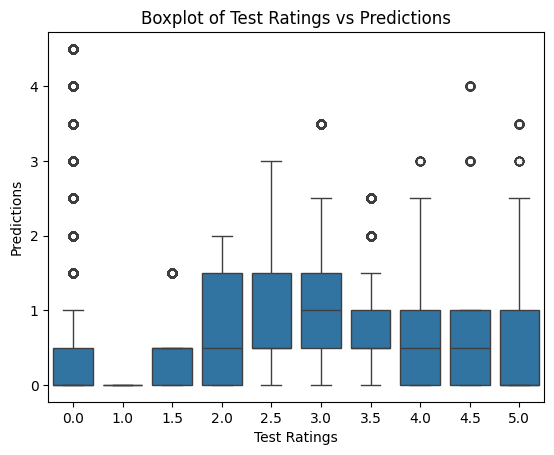

rmse:  2.810774626573377
r2:  -0.17216375880241297
Fraction of user-movie pairs with non-zero predicted ratings  0.42423756876568924
Fraction of user-movie pairs with non-zero predicted ratings  0.47455446954725916


In [ ]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 5, 'euclidean', False, 'l2')

predictions_array, test_ratings_array = compute_predictions(avg_rat_model, input_ratings, test_ratings)
show_box_plot(test_ratings_array, predictions_array)
print_stats(test_ratings_array, predictions_array)

<H2>Ecludian, 5 neighbor, TDFIF l2<h2>

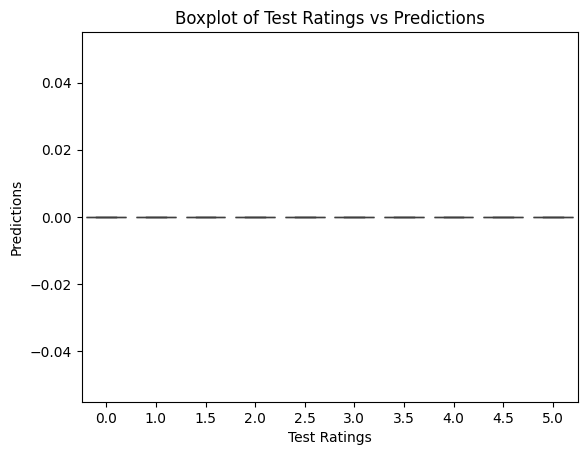

rmse:  3.219948703624254
r2:  -0.34279964672672114
Fraction of user-movie pairs with non-zero predicted ratings  0.05437162847834215
Fraction of user-movie pairs with non-zero predicted ratings  0.27257027897950825


In [ ]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 5, 'euclidean', True, 'l2')

predictions_array, test_ratings_array = compute_predictions(avg_rat_model, input_ratings, test_ratings, True, 'l2')
show_box_plot(test_ratings_array, predictions_array)
print_stats(test_ratings_array, predictions_array)

<H2>Ecludian, 5 neighbor, TDFIF None<h2>

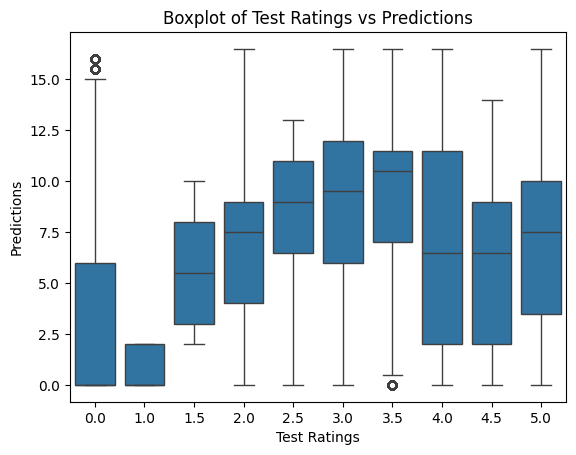

rmse:  30.276400490928317
r2:  -11.626020979034655
Fraction of user-movie pairs with non-zero predicted ratings  0.562725880823942
Fraction of user-movie pairs with non-zero predicted ratings  0.5897336609161637


In [ ]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 5, 'euclidean', True, None)

predictions_array, test_ratings_array = compute_predictions(avg_rat_model, input_ratings, test_ratings, True, None)
show_box_plot(test_ratings_array, predictions_array)
print_stats(test_ratings_array, predictions_array)

<H2>Cosine, 5 neighbor, TDFIF None<h2>

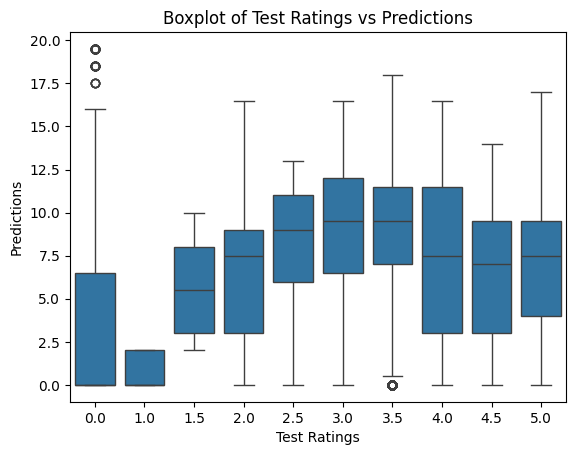

In [ ]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 5, 'cosine', True, None)

predictions_array, test_ratings_array = compute_predictions(avg_rat_model, input_ratings, test_ratings, True, None)
show_box_plot(test_ratings_array, predictions_array)

<H2>Cosine, 10 neighbor</h2>

In [ ]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 10, 'cosine', True, None)

predictions_array, test_ratings_array = compute_predictions(avg_rat_model, input_ratings, test_ratings, True, None)
show_box_plot(test_ratings_array, predictions_array)

KeyboardInterrupt: 

<H2>Cosine, 25 neighbor</h2>

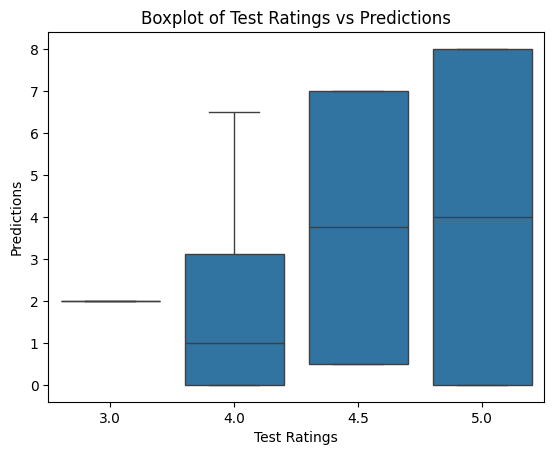

In [ ]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 25, 'cosine', True, None)

predictions_array, test_ratings_array = compute_predictions(avg_rat_model, input_ratings, test_ratings, True, None)
show_box_plot(test_ratings_array, predictions_array)

<H2>Cosine, 50 neighbor</h2>

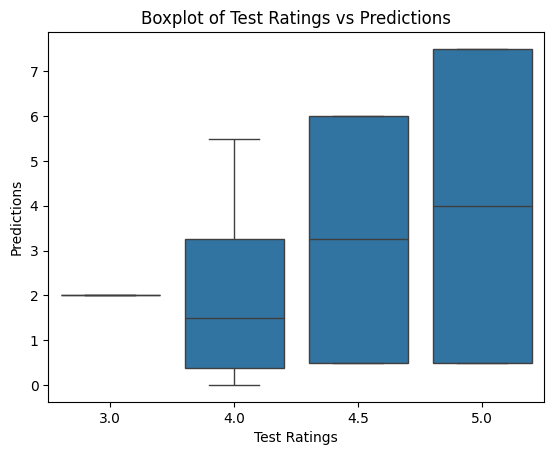

In [ ]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 50, 'cosine', True, None)

predictions_array, test_ratings_array = compute_predictions(avg_rat_model, input_ratings, test_ratings, True, None)
show_box_plot(test_ratings_array, predictions_array)

<H2>Cosine, 100 neighbor</h2>

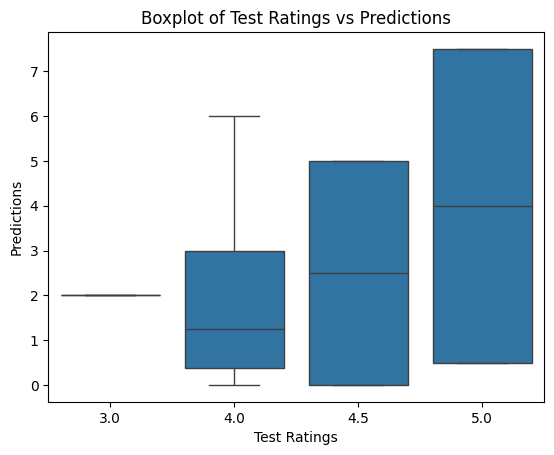

In [ ]:
avg_rat_model = KNNAverageRatingModel()

avg_rat_model.fit(train_dataset, 100, 'cosine', True, None)

predictions_array, test_ratings_array = compute_predictions(avg_rat_model, input_ratings, test_ratings, True, None)
show_box_plot(test_ratings_array, predictions_array)